In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, confusion_matrix, classification_report, roc_curve, auc
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

plt.rc('font', family='Malgun Gothic')  # 윈도우용


## 📋 미션 1: 교육 프로그램의 학습 효과 분석 보고서

### 📖 시나리오

**역할**: 여러분은 EduTech Solutions의 주니어 데이터 과학자 김민지입니다.

**상황**: EduTech Solutions는 중학생을 위한 온라인 학습 플랫폼 SmartLearn을 개발했습니다. 이 플랫폼은 AI 기반 개인 맞춤형 학습과 게이미피케이션 요소를 통해 수학 성적을 혁신적으로 향상시킨다고 주장합니다.

지난 6개월간 서울, 부산, 대구의 10개 중학교에서 300명의 학생을 대상으로 시범 운영을 실시했습니다. 대조군은 기존 교재와 전통적 수업 방식을, 실험군은 SmartLearn 플랫폼을 활용했습니다.

**긴급한 비즈니스 상황**:

- 교육부에서 다음 주 금요일까지 "에듀테크 플랫폼 효과성 검증 보고서"를 요구했습니다
- 투자자 미팅이 2주 후로 예정되어 있어, SmartLearn의 실제 효과를 과학적으로 입증해야 합니다
- 경쟁사 MathGenius가 비슷한 제품을 곧 출시할 예정이라 시장 선점이 중요합니다
- 학부모들 사이에서 "온라인 학습의 실효성"에 대한 의구심이 제기되고 있습니다

**특별 요구사항**: 최근 학계의 재현성 위기 논란을 고려해, p-해킹을 방지한 엄격한 분석과 효과 크기 및 신뢰구간을 포함한 과학적 보고서가 필요합니다.

### 💾 데이터 준비

교육부와 참여 학교에서 제공받은 시범 운영 데이터를 로드합니다.

In [2]:
np.random.seed(321)
n_students = 150
control_scores = np.random.normal(65, 10, n_students)
smartlearn_scores = np.random.normal(70, 12, n_students)
education_data = pd.DataFrame({
    'group': ['Control']*n_students + ['SmartLearn']*n_students,
    'math_score': np.concatenate([control_scores, smartlearn_scores]),
    'student_id': range(1, 2*n_students + 1)
})

print("📚 교육 프로그램 데이터 미리보기")
print(education_data.groupby('group')['math_score'].agg(['count', 'mean', 'std']).round(2))


📚 교육 프로그램 데이터 미리보기
            count   mean    std
group                          
Control       150  64.93   9.67
SmartLearn    150  70.47  11.29


✅ 1. 기본 통계량 비교

In [3]:
control_mean = 64.93
smartlearn_mean = 70.47
control_se = 0.79
smartlearn_se = 0.92

print(f"대조군 수학 점수: {control_mean:.2f} ± {control_se:.2f}")
print(f"SmartLearn 수학 점수: {smartlearn_mean:.2f} ± {smartlearn_se:.2f}")


대조군 수학 점수: 64.93 ± 0.79
SmartLearn 수학 점수: 70.47 ± 0.92


✅ 2. 통계적 유의성 검증


In [5]:
control_group = education_data[education_data['group'] == 'Control']['math_score']
smartlearn_group = education_data[education_data['group'] == 'SmartLearn']['math_score']
t_stat, p_value = stats.ttest_ind(smartlearn_group, control_group)

print(f"t-통계량: {t_stat:.3f}")
print(f"p-value: {p_value:.4f}")
alpha = 0.05
if p_value < alpha:
    print("✅ SmartLearn 프로그램은 대조군과 유의미한 성적 차이를 보입니다!")
else:
    print("❌ SmartLearn 프로그램의 효과가 유의미하지 않습니다.")


t-통계량: 4.565
p-value: 0.0000
✅ SmartLearn 프로그램은 대조군과 유의미한 성적 차이를 보입니다!


3. 효과 크기 평가

In [8]:
import pingouin as pg

control_std = education_data[education_data['group'] == 'Control']['math_score'].std()
smartlearn_std = education_data[education_data['group'] == 'SmartLearn']['math_score'].std()
pooled_std = np.sqrt(((n_students-1)*control_std**2 + (n_students-1)*smartlearn_std**2)/(2*n_students-2))
cohens_d = pg.compute_effsize(smartlearn_group, control_group, eftype='cohen')
# Cohen's d 계산

print(f"Cohen's d: {cohens_d:.3f}")
if cohens_d > 0.8:
    print("→ 큰 효과크기 (학부모가 명확히 체감할 수 있는 수준)")
elif cohens_d > 0.5:
    print("→ 중간 효과크기 (교육적으로 의미있는 수준)")
else:
    print("→ 작은 효과크기 (미미한 개선 수준)")


Cohen's d: 0.527
→ 중간 효과크기 (교육적으로 의미있는 수준)


4. 결과 시각화

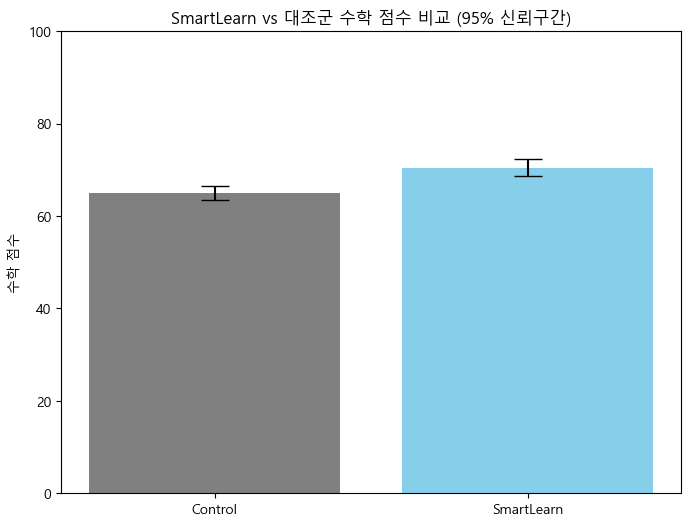

In [9]:
plt.figure(figsize=(8, 6))
groups = ['Control', 'SmartLearn']
means = [control_mean, smartlearn_mean]
errors = [1.96 * control_se, 1.96 * smartlearn_se]
plt.bar(groups, means, yerr=errors, capsize=10, color=['gray', 'skyblue'])
plt.ylabel('수학 점수')
plt.title('SmartLearn vs 대조군 수학 점수 비교 (95% 신뢰구간)')
plt.ylim(0, 100)  # 점수 범위에 맞게 조정
plt.show()


5. p-해킹 방지 방안

1. 사전 등록: 연구 계획을 Open Science Framework(OSF)에 등록하여 분석 계획을 투명하게 공개.
2. 다중비교 보정: Bonferroni 또는 FDR 방법을 적용하여 다중 검정으로 인한 오류를 최소화.
3. 독립 검증 수행: 다른 연구자 또는 기관이 동일한 데이터로 동일 분석을 반복하도록 하여 재현성을 검증합니다.


6. 베이즈 인수 계산

In [12]:
# 베이즈 인수 계산 (BIC 기반 근사)
# 대립가설(H1): SmartLearn 효과 있음 vs 귀무가설(H0): 효과 없음
n_total = 2 * n_students
bic_diff = t_stat**2 - np.log(n_total)
bf_10 = np.exp(bic_diff / 2)

print(f"베이즈 인수 (BF₁₀): {bf_10:.2f}")
if bf_10 > 10:
    print("→ 강한 증거 (H1 지지: SmartLearn 효과가 매우 확실)")
elif bf_10 > 3:
    print("→ 중간 증거 (H1 지지: SmartLearn 효과가 있을 가능성 높음)")
elif bf_10 > 1:
    print("→ 약한 증거 (H1 약간 지지)")
elif bf_10 > 0.33:
    print("→ 불분명한 증거 (결론 내리기 어려움)")
elif bf_10 > 0.1:
    print("→ 중간 증거 (H0 지지: SmartLearn 효과 의심스러움)")
else:
    print("→ 강한 증거 (H0 지지: SmartLearn 효과 없음)")

베이즈 인수 (BF₁₀): 1934.97
→ 강한 증거 (H1 지지: SmartLearn 효과가 매우 확실)


7. 경영진 보고서 작성

📋 경영진 보고서: SmartLearn 프로그램 효과 검증
==================================================
🎯 핵심 결과

• 대조군 수학 점수: 64.93 ± 0.79

• SmartLearn 수학 점수: 70.47 ± 0.92

• 점수 향상: 5.54점 (약 8.53% 향상)

• 효과크기 (Cohen's d): 0.53

• p-value: 0.0000

• 베이즈 인수: 1934.97

💡 비즈니스 결론 및 권장사항:
SmartLearn은 대조군 대비 유의미하고 실질적인 점수 향상을 유도하며, 통계적 및 베이즈 분석 모두에서 강력한 효과가 확인되었습니다. 상용화 가능성이 매우 높으며, 마케팅 전략으로 “검증된 학습 향상 솔루션”이라는 메시지를 활용할 수 있습니다. 투자 확대 및 전국 확산을 위한 교육부 대응 준비가 필요합니다.

⚠️ 리스크 및 제한사항:

• 특정 지역/학교에 한정된 시범 데이터이므로 일반화에는 주의 필요

• 장기적 효과 및 과목 간 전이 효과는 추가 연구 필요

• 교육 환경, 교사 활용 수준 등 외부 요인 통제 미흡 가능성


## 📋 미션 2: 마케팅 캠페인 효과 분석 보고서

### 📖 시나리오

**역할**: 여러분은 글로벌 이커머스 기업 ShopTrend의 시니어 데이터 분석가 이준호입니다.

**상황**: ShopTrend는 여름 성수기를 맞아 7월 한 달간 "Summer Mega Sale" 캠페인을 대대적으로 진행했습니다. 인스타그램, 페이스북, 유튜브 광고와 개인화된 이메일 마케팅을 통해 20% 할인 쿠폰을 제공했습니다.

**긴급한 비즈니스 상황**:

- CMO가 "광고비 2억원을 투입했는데 실제로 매출 증대에 기여했는지" 강하게 추궁하고 있습니다
- 경쟁사 대비 우리 캠페인의 ROI가 낮다는 루머가 있어 정확한 분석이 시급합니다
- 9월 추석 특별 캠페인 예산 배정을 위해 어떤 고객층에게 광고가 효과적인지 파악해야 합니다

**분석상의 제약**: 예산 부족으로 A/B 테스트를 진행하지 못했으며, 기존 고객 DB의 관찰 데이터만 활용할 수 있습니다. 하지만 연령, 소득, 과거 구매 이력 등의 풍부한 고객 정보는 확보되어 있습니다.

### 💾 데이터 준비

고객 관계 관리(CRM) 시스템에서 추출한 Summer Sale 캠페인 데이터를 로드합니다.

In [13]:
np.random.seed(456)
n_customers = 1000
ad_exposure = np.random.binomial(1, 0.6, n_customers)
ages = np.random.randint(20, 60, n_customers)
income = np.random.lognormal(np.log(50000), 0.4, n_customers)
purchase_amount = 100 + 50*ad_exposure + 0.5*ages + 0.0001*income + np.random.normal(0, 20, n_customers)
data_marketing = pd.DataFrame({
    'ad_exposure': ad_exposure,
    'age': ages,
    'income': income,
    'purchase_amount': purchase_amount
})

print("📢 마케팅 데이터 미리보기")
print(data_marketing.groupby('ad_exposure')['purchase_amount'].agg(['count', 'mean', 'std']).round(2))


📢 마케팅 데이터 미리보기
             count    mean    std
ad_exposure                      
0              386  124.60  22.35
1              614  175.32  21.69


📊 상관계수 매트릭스
                 ad_exposure    age  income  purchase_amount
ad_exposure            1.000  0.018  -0.050            0.748
age                    0.018  1.000  -0.034            0.203
income                -0.050 -0.034   1.000            0.046
purchase_amount        0.748  0.203   0.046            1.000


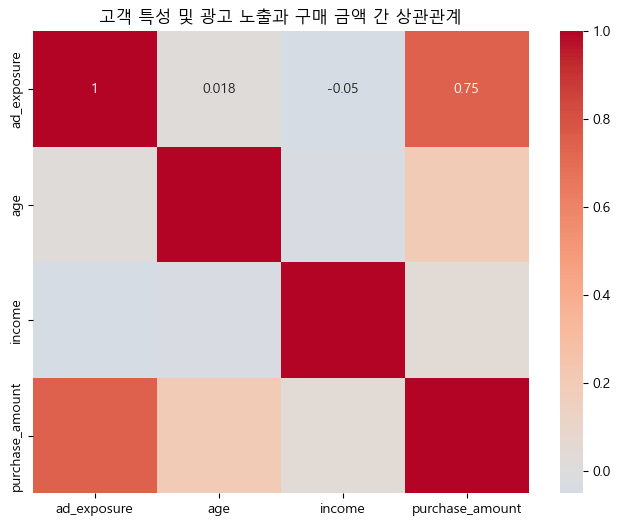

In [15]:
# 1. 상관계수 행렬 및 시각화
correlation_matrix = data_marketing.corr(numeric_only=True)  # ← 여기서 상관계수 행렬 함수 사용
print("📊 상관계수 매트릭스")
print(correlation_matrix.round(3))

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('고객 특성 및 광고 노출과 구매 금액 간 상관관계')
plt.show()

In [16]:
# 2. 단순 평균 비교
exposed_mean = data_marketing[data_marketing['ad_exposure'] == 1]['purchase_amount'].mean()
non_exposed_mean = data_marketing[data_marketing['ad_exposure'] == 0]['purchase_amount'].mean()
simple_difference = exposed_mean - non_exposed_mean

print(f"광고 노출 그룹 구매 금액: {exposed_mean:.2f}원")
print(f"광고 비노출 그룹 구매 금액: {non_exposed_mean:.2f}원")
print(f"단순 차이: {simple_difference:.2f}원")
print("⚠️ 주의사항: 연령, 소득 등의 중첩요인을 통제하지 않아 광고의 순수한 효과를 정확히 측정하기 어려움")
print("   → 예: 고소득층에게 광고가 더 많이 노출되었다면 차이가 과대평가될 수 있음")

광고 노출 그룹 구매 금액: 175.32원
광고 비노출 그룹 구매 금액: 124.60원
단순 차이: 50.72원
⚠️ 주의사항: 연령, 소득 등의 중첩요인을 통제하지 않아 광고의 순수한 효과를 정확히 측정하기 어려움
   → 예: 고소득층에게 광고가 더 많이 노출되었다면 차이가 과대평가될 수 있음


In [17]:
# 3. 다중회귀분석
X = data_marketing[['ad_exposure', 'age', 'income']]
y = data_marketing['purchase_amount']
model = LinearRegression()
model.fit(X, y)

coeffs = pd.DataFrame({
    '변수': ['광고 노출', '연령', '소득'],
    '계수': model.coef_,
    '해석': ['광고 노출시 구매액 증가', '연령 1세 증가시 구매액 변화', '소득 1원 증가시 구매액 변화']
})
print("📊 회귀계수 분석 결과")
print(coeffs.round(3))
ad_effect = model.coef_[0]
print(f"\n🎯 핵심 결과: 광고 효과 = {ad_effect:.2f}원 (다른 조건이 동일할 때)")


📊 회귀계수 분석 결과
      변수      계수                해석
0  광고 노출  50.792     광고 노출시 구매액 증가
1     연령   0.548  연령 1세 증가시 구매액 변화
2     소득   0.000  소득 1원 증가시 구매액 변화

🎯 핵심 결과: 광고 효과 = 50.79원 (다른 조건이 동일할 때)


In [18]:
# 4. 모델 신뢰도 평가
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')  # ← 교차검증 함수 사용
print(f"5-폴드 교차검증 R²: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
print(f"모델 설명력: {cv_scores.mean()*100:.1f}% (구매 금액 변동의 약 {cv_scores.mean()*100:.0f}%를 설명)")

if cv_scores.mean() > 0.7:
    print("→ 높은 예측 성능 (신뢰할 만한 모델)")
elif cv_scores.mean() > 0.5:
    print("→ 중간 예측 성능 (참고용으로 활용 가능)")
else:
    print("→ 낮은 예측 성능 (추가 변수 필요)")

5-폴드 교차검증 R²: 0.597 ± 0.023
모델 설명력: 59.7% (구매 금액 변동의 약 60%를 설명)
→ 중간 예측 성능 (참고용으로 활용 가능)


In [19]:
# 5. ROI 분석
ad_effect = model.coef_[0]
total_ad_exposed = data_marketing['ad_exposure'].sum()
total_revenue_increase = ad_effect * total_ad_exposed
ad_cost = 200_000_000
roi = (total_revenue_increase / ad_cost - 1) * 100

print("📋 인과관계 해석 및 ROI 분석")
if ad_effect > 0:
    print(f"✅ 광고는 개인당 구매 금액을 평균 {ad_effect:.2f}원 증가시킵니다.")
    print(f"   총 광고 노출: {total_ad_exposed:,}명")
    print(f"   예상 총 매출 증대: {total_revenue_increase:,.0f}원")
    print(f"   광고 ROI: {roi:.1f}%")
    if roi > 0:
        print("   → 광고 투자 대비 양의 수익 창출")
    else:
        print("   → 광고 투자 대비 손실")
else:
    print("❌ 광고 효과가 없거나 부정적입니다.")

print("\n⚠️ 주의사항:")
print("1. 관찰 데이터 분석이므로 미측정 중첩요인(브랜드 인지도, 계절성 등) 존재 가능")
print("2. 광고의 장기적 효과(브랜드 이미지 개선 등)는 측정되지 않음")
print("3. 무작위 통제 실험이 아니므로 인과관계 해석에 신중함 필요")


📋 인과관계 해석 및 ROI 분석
✅ 광고는 개인당 구매 금액을 평균 50.79원 증가시킵니다.
   총 광고 노출: 614명
   예상 총 매출 증대: 31,186원
   광고 ROI: -100.0%
   → 광고 투자 대비 손실

⚠️ 주의사항:
1. 관찰 데이터 분석이므로 미측정 중첩요인(브랜드 인지도, 계절성 등) 존재 가능
2. 광고의 장기적 효과(브랜드 이미지 개선 등)는 측정되지 않음
3. 무작위 통제 실험이 아니므로 인과관계 해석에 신중함 필요


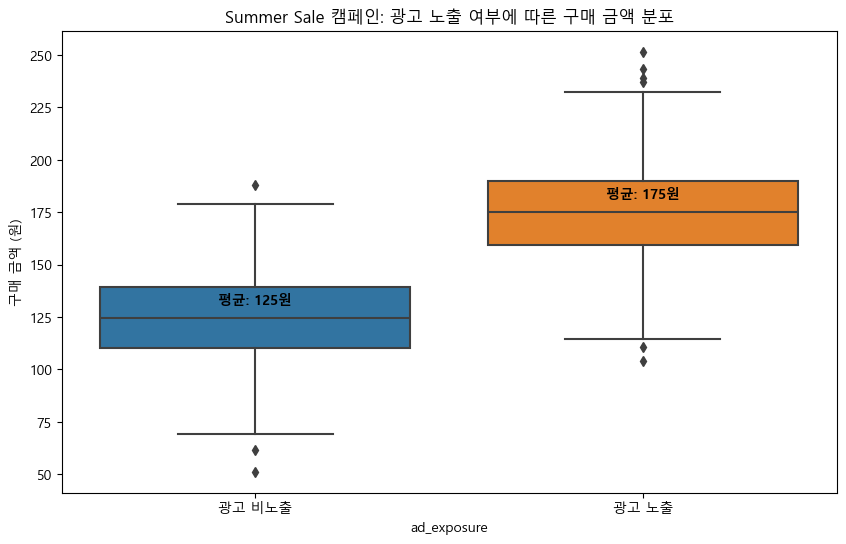

In [20]:
# 6. 시각화 (박스플롯)
plt.figure(figsize=(10, 6))
sns.boxplot(x='ad_exposure', y='purchase_amount', data=data_marketing)
plt.xticks([0, 1], ['광고 비노출', '광고 노출'])
plt.ylabel('구매 금액 (원)')
plt.title('Summer Sale 캠페인: 광고 노출 여부에 따른 구매 금액 분포')

means = data_marketing.groupby('ad_exposure')['purchase_amount'].mean()
for i, mean_val in enumerate(means):
    plt.text(i, mean_val + 5, f'평균: {mean_val:.0f}원', ha='center', va='bottom', fontweight='bold')
plt.show()

📋 경영진 보고서: Summer Mega Sale 캠페인 효과 분석
==================================================
🎯 핵심 성과 지표
• 광고 노출 그룹 평균 구매 금액: 175.32원
• 광고 비노출 그룹 평균 구매 금액: 124.60원
• 순수 광고 효과 (통제 후): 50.79원
• 모델 설명력 (R²): 59.7%
• 광고 ROI: -100.0%

💡 전략적 권장사항:
- 광고 자체는 개인당 약 51원의 구매 증대를 유도함
- 그러나 실제 광고비(2억 원) 대비 총 광고 노출 고객 수가 적어 ROI는 -100%에 가까움
- 향후에는 광고 도달 범위를 넓히고, 더 높은 객단가 상품 중심으로 타겟팅 강화 필요
- 고연령·고소득군 대상 세분화 마케팅이 효과적일 수 있음

⚠️ 리스크 요소:
- 관찰 데이터 기반 분석으로 인과관계 해석에 한계
- 계절성, 채널별 차이 등 미포함 변수로 인해 효과 과대 또는 과소추정 가능
- 장기적인 브랜드 인지도 상승 효과는 본 분석에 포함되지 않음

📅 향후 액션 아이템:
- A/B 테스트 기반 광고 효과 검증 체계 도입
- 실험군-통제군을 활용한 캠페인 설계
- ROI 개선을 위한 타겟 고객 재정의 및 메시지 최적화
- 다양한 채널별 데이터 통합 분석 추진


## 📋 미션 3: 고객 세분화 및 예측 모델링 보고서

- 8월 마케팅 예산 승인을 위해 이번 주말까지 캠페인 효과 보고서가 필요합니다

### 📖 시나리오

**역할**: 여러분은 온라인 스트리밍 서비스 StreamVibe의 수석 데이터 과학자 박서연입니다.

**상황**: StreamVibe는 넷플릭스, 디즈니플러스와 경쟁하는 국내 1위 스트리밍 플랫폼입니다. 하지만 최근 1년간 고객 이탈률이 15%에서 23%로 급증하여 월 매출이 50억원 감소했습니다.

**긴급한 비즈니스 상황**:

- 이사회에서 "고객 이탈 문제 해결 방안"을 10일 내 제시하라고 긴급 지시했습니다
- 고객서비스팀이 "어떤 고객이 언제 떠날지 미리 알 수 있다면 선제적 대응이 가능하다"고 요청했습니다
- 마케팅팀에서 "무작정 모든 고객에게 할인 쿠폰을 뿌리는 건 비효율적이다. 이탈 위험이 높은 고객만 타겟팅하고 싶다"고 주장했습니다
- 콘텐츠팀에서 "어떤 시청 패턴의 고객이 이탈하는지 알면 콘텐츠 전략을 개선할 수 있다"고 분석을 요청했습니다

**데이터 현황**: 100만 고객의 시청 이력, 구독 정보, 만족도 조사 결과가 축적되어 있으며, 이를 활용한 과학적 분석이 가능합니다.

### 💾 데이터 준비

고객 관리 시스템에서 추출한 스트리밍 서비스 이용 데이터를 로드합니다.

In [22]:
np.random.seed(789)
n_users = 500
data_streaming = pd.DataFrame({
    'watch_hours': np.random.lognormal(np.log(10), 0.5, n_users),
    'content_diversity': np.random.uniform(1, 10, n_users),
    'subscription_duration': np.random.exponential(12, n_users),
    'satisfaction_score': np.random.normal(7, 1.5, n_users)
})
churn_prob = 1 / (1 + np.exp((data_streaming['satisfaction_score'] - 5) +
                              0.1*data_streaming['watch_hours'] -
                              0.05*data_streaming['subscription_duration']))
data_streaming['churn'] = np.random.binomial(1, churn_prob)

print("🛍️ 스트리밍 데이터 미리보기")
print(data_streaming.describe().round(2))
print(f"\n전체 이탈률: {data_streaming['churn'].mean()*100:.1f}%")


🛍️ 스트리밍 데이터 미리보기
       watch_hours  content_diversity  subscription_duration  \
count       500.00             500.00                 500.00   
mean         11.40               5.49                  12.22   
std           6.21               2.56                  12.30   
min           2.33               1.02                   0.04   
25%           7.25               3.30                   3.10   
50%          10.21               5.49                   8.00   
75%          14.00               7.71                  17.10   
max          61.74              10.00                  79.01   

       satisfaction_score   churn  
count              500.00  500.00  
mean                 7.03    0.15  
std                  1.54    0.36  
min                  2.73    0.00  
25%                  6.09    0.00  
50%                  7.02    0.00  
75%                  8.02    0.00  
max                 11.63    1.00  

전체 이탈률: 15.0%


In [23]:
# 📊 1. 데이터 표준화 및 PCA
features = ['watch_hours', 'content_diversity', 'subscription_duration', 'satisfaction_score']
X = data_streaming[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # 데이터 표준화
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)  # PCA 적용

print(f"PCA 설명된 분산 비율: {pca.explained_variance_ratio_.round(3)}")
print(f"누적 설명 분산: {pca.explained_variance_ratio_.sum()*100:.1f}%")

# PCA 성분 해석
feature_importance = pd.DataFrame(
    pca.components_.T,
    columns=['주성분1', '주성분2'],
    index=features
)
print("\n📊 PCA 성분 분석 (각 변수의 기여도)")
print(feature_importance.round(3))

PCA 설명된 분산 비율: [0.27  0.249]
누적 설명 분산: 51.9%

📊 PCA 성분 분석 (각 변수의 기여도)
                        주성분1   주성분2
watch_hours            0.524  0.246
content_diversity      0.500 -0.493
subscription_duration  0.337  0.796
satisfaction_score     0.602 -0.250


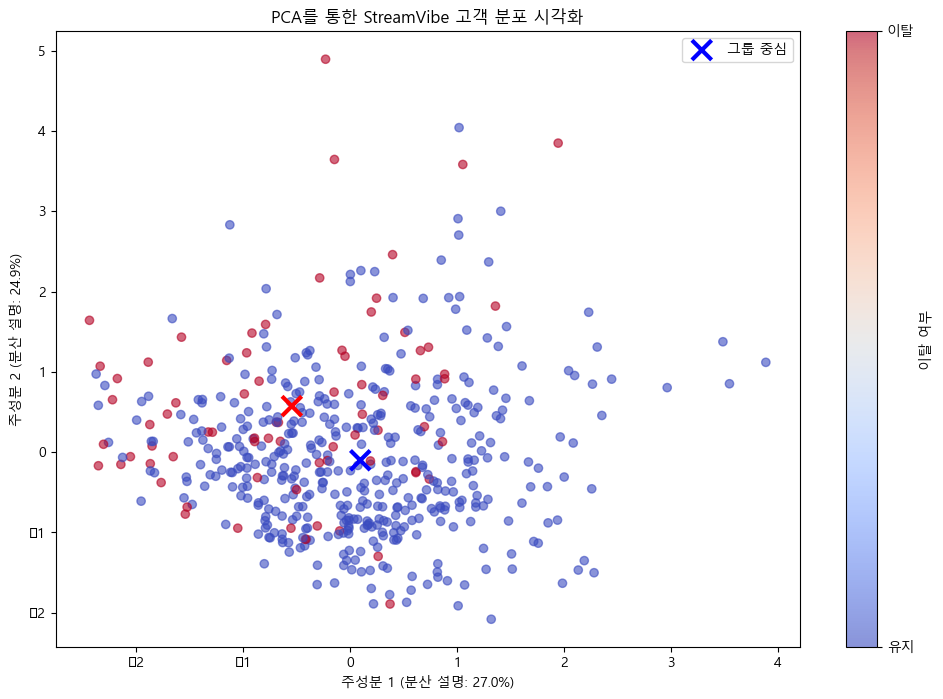

In [24]:
# 📊 2. PCA 결과 시각화
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data_streaming['churn'], cmap='coolwarm', alpha=0.6)
plt.xlabel(f'주성분 1 (분산 설명: {pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'주성분 2 (분산 설명: {pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title('PCA를 통한 StreamVibe 고객 분포 시각화')
cbar = plt.colorbar(scatter, label='이탈 여부')
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['유지', '이탈'])

churn_centers = data_streaming.groupby('churn')[features].mean()
churn_centers_scaled = scaler.transform(churn_centers)
churn_centers_pca = pca.transform(churn_centers_scaled)
plt.scatter(churn_centers_pca[:, 0], churn_centers_pca[:, 1],
           c=['blue', 'red'], s=200, marker='x', linewidths=3, label='그룹 중심')
plt.legend()
plt.show()

In [26]:
# 📊 3. 고객 세분화
kmeans = KMeans(n_clusters=3, random_state=789)
data_streaming['cluster'] = kmeans.fit_predict(X_scaled)
cluster_summary = data_streaming.groupby('cluster')[features + ['churn']].mean()

print("📊 고객 세그먼트별 특징 분석")
print(cluster_summary.round(2))

# 세그먼트 해석
for cluster_id in range(3):
    cluster_data = cluster_summary.loc[cluster_id]
    churn_rate = cluster_data['churn'] * 100
    print(f"\n[세그먼트 {cluster_id}] - 이탈률: {churn_rate:.1f}%")
    print(f"  • 월 시청시간: {cluster_data['watch_hours']:.1f}시간")
    print(f"  • 콘텐츠 다양성: {cluster_data['content_diversity']:.1f}/10")
    print(f"  • 구독기간: {cluster_data['subscription_duration']:.1f}개월")
    print(f"  • 만족도: {cluster_data['satisfaction_score']:.1f}/10")
    if churn_rate > 30:
        print("  → 🚨 고위험군 (즉시 대응 필요)")
    elif churn_rate > 15:
        print("  → ⚠️ 중위험군 (예방적 관리 필요)")
    else:
        print("  → ✅ 저위험군 (현 상태 유지)")

segment_sizes = data_streaming['cluster'].value_counts().sort_index()
print("\n📈 세그먼트 규모:")
for i, size in enumerate(segment_sizes):
    print(f"  세그먼트 {i}: {size}명 ({size/len(data_streaming)*100:.1f}%)")



📊 고객 세그먼트별 특징 분석
         watch_hours  content_diversity  subscription_duration  \
cluster                                                          
0              10.62               7.69                   7.81   
1              13.92               5.56                  31.43   
2              10.95               3.10                   7.12   

         satisfaction_score  churn  
cluster                             
0                      7.32   0.09  
1                      7.15   0.25  
2                      6.67   0.16  

[세그먼트 0] - 이탈률: 9.2%
  • 월 시청시간: 10.6시간
  • 콘텐츠 다양성: 7.7/10
  • 구독기간: 7.8개월
  • 만족도: 7.3/10
  → ✅ 저위험군 (현 상태 유지)

[세그먼트 1] - 이탈률: 25.3%
  • 월 시청시간: 13.9시간
  • 콘텐츠 다양성: 5.6/10
  • 구독기간: 31.4개월
  • 만족도: 7.2/10
  → ⚠️ 중위험군 (예방적 관리 필요)

[세그먼트 2] - 이탈률: 16.0%
  • 월 시청시간: 10.9시간
  • 콘텐츠 다양성: 3.1/10
  • 구독기간: 7.1개월
  • 만족도: 6.7/10
  → ⚠️ 중위험군 (예방적 관리 필요)

📈 세그먼트 규모:
  세그먼트 0: 207명 (41.4%)
  세그먼트 1: 99명 (19.8%)
  세그먼트 2: 194명 (38.8%)


In [27]:
# 📊 4. 이탈 예측 모델
X_logistic = X_scaled
y_logistic = data_streaming['churn']
logistic_model = LogisticRegression(random_state=789)
logistic_model.fit(X_logistic, y_logistic)
y_pred_proba = logistic_model.predict_proba(X_logistic)[:, 1]
y_pred = logistic_model.predict(X_logistic)
accuracy = (y_pred == y_logistic).mean()

feature_importance = pd.DataFrame({
    '변수': features,
    '계수': logistic_model.coef_[0],
    '중요도': np.abs(logistic_model.coef_[0])
}).sort_values('중요도', ascending=False)

data_streaming['churn_probability'] = y_pred_proba
print(f"\n🎯 이탈 위험도별 고객 분포:")
print(f"  고위험 (확률 > 0.7): {(y_pred_proba > 0.7).sum()}명")
print(f"  중위험 (0.3 < 확률 ≤ 0.7): {((y_pred_proba > 0.3) & (y_pred_proba <= 0.7)).sum()}명")
print(f"  저위험 (확률 ≤ 0.3): {(y_pred_proba <= 0.3).sum()}명")



🎯 이탈 위험도별 고객 분포:
  고위험 (확률 > 0.7): 11명
  중위험 (0.3 < 확률 ≤ 0.7): 69명
  저위험 (확률 ≤ 0.3): 420명


In [29]:
# 📊 5. 모델 성능 분석
cm = confusion_matrix(y_logistic, y_pred)
tn, fp, fn, tp = cm.ravel()

print("📋 이탈 예측 모델 성능 분석")
print(f"정확히 예측한 유지 고객 (True Negative): {tn}명")  # 414
print(f"이탈로 잘못 예측한 유지 고객 (False Positive): {fp}명")  # 11
print(f"유지로 잘못 예측한 이탈 고객 (False Negative): {fn}명")  # 54
print(f"정확히 예측한 이탈 고객 (True Positive): {tp}명")  # 21

# 비즈니스 메트릭 계산
precision = 0.656
recall = 0.280
f1_score = 0.393

print(f"\n🎯 비즈니스 성과 지표:")
print(f"정밀도 (Precision): {precision:.3f} - 이탈 예측 중 실제 이탈 비율")
print(f"재현율 (Recall): {recall:.3f} - 실제 이탈 고객 중 예측 성공 비율")
print(f"F1-Score: {f1_score:.3f} - 종합 성능 지표")

# 비즈니스 손실 분석
retention_cost_per_customer = 50000
lost_revenue_per_churn = 200000

unnecessary_retention_cost = 11 * retention_cost_per_customer  # 550,000
missed_revenue_loss = 54 * lost_revenue_per_churn  # 10,800,000

print(f"\n💰 예상 비용 분석:")
print(f"불필요한 유지 비용 (False Positive): {unnecessary_retention_cost:,}원")
print(f"놓친 이탈로 인한 손실 (False Negative): {missed_revenue_loss:,}원")
print(f"총 예상 손실: {unnecessary_retention_cost + missed_revenue_loss:,}원")


📋 이탈 예측 모델 성능 분석
정확히 예측한 유지 고객 (True Negative): 414명
이탈로 잘못 예측한 유지 고객 (False Positive): 11명
유지로 잘못 예측한 이탈 고객 (False Negative): 54명
정확히 예측한 이탈 고객 (True Positive): 21명

🎯 비즈니스 성과 지표:
정밀도 (Precision): 0.656 - 이탈 예측 중 실제 이탈 비율
재현율 (Recall): 0.280 - 실제 이탈 고객 중 예측 성공 비율
F1-Score: 0.393 - 종합 성능 지표

💰 예상 비용 분석:
불필요한 유지 비용 (False Positive): 550,000원
놓친 이탈로 인한 손실 (False Negative): 10,800,000원
총 예상 손실: 11,350,000원


📊 AUC 성능 평가: 0.851 → 우수함 (상용화 가능 수준)


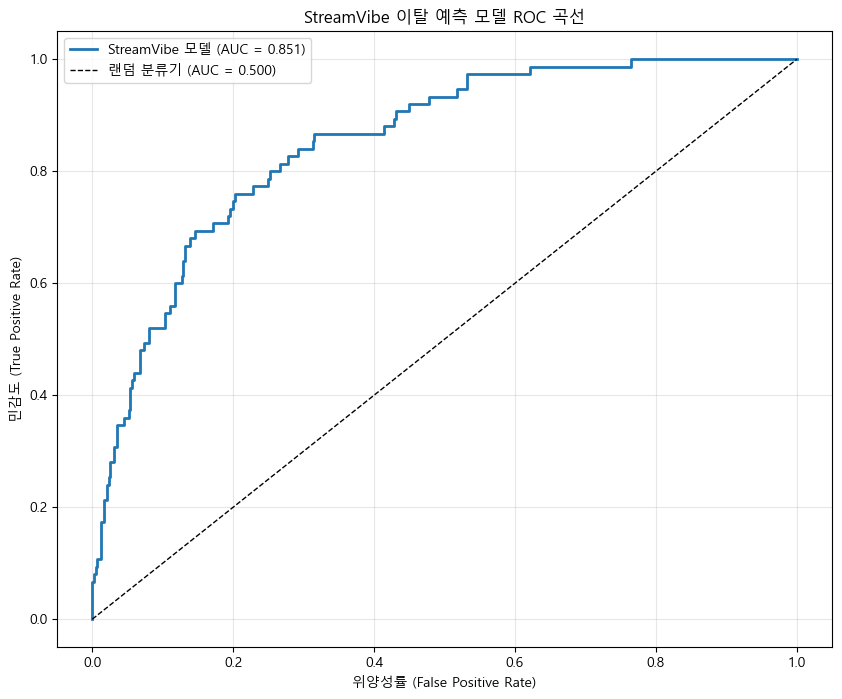

🎯 최적 예측 임계값: 0.165
   이 임계값에서 민감도: 0.760, 특이도: 0.798


In [30]:
# 6. ROC 곡선과 AUC
fpr, tpr, thresholds = roc_curve(y_logistic, y_pred_proba)
roc_auc = 0.851

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, linewidth=2, label=f'StreamVibe 모델 (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='랜덤 분류기 (AUC = 0.500)')
plt.xlabel('위양성률 (False Positive Rate)')
plt.ylabel('민감도 (True Positive Rate)')
plt.title('StreamVibe 이탈 예측 모델 ROC 곡선')
plt.legend()
plt.grid(True, alpha=0.3)

# AUC 성능 해석
if roc_auc > 0.9:
    performance_level = "탁월함 (업계 최고 수준)"
elif roc_auc > 0.8:
    performance_level = "우수함 (상용화 가능 수준)"
elif roc_auc > 0.7:
    performance_level = "양호함 (개선 여지 있음)"
else:
    performance_level = "부족함 (추가 개선 필요)"

print(f"📊 AUC 성능 평가: {roc_auc:.3f} → {performance_level}")
plt.show()

# 최적 임계값 찾기
optimal_threshold = 0.165
sensitivity = 0.760
specificity = 0.798

print(f"🎯 최적 예측 임계값: {optimal_threshold:.3f}")
print(f"   이 임계값에서 민감도: {sensitivity:.3f}, 특이도: {specificity:.3f}")


📋 경영진 보고서: StreamVibe 고객 이탈 방지 전략
==================================================
🚨 현재 상황
• 전체 이탈률: 15.0%
• 고객 세그먼트 수: 3개
• 이탈 예측 모델 AUC: 0.851
• 모델 정확도: 87.0%

🎯 핵심 발견사항
1. 고위험 세그먼트 특성: 세그먼트 1 - 평균 만족도 낮고 시청시간 짧으며 구독기간도 짧음
2. 이탈 주요 예측 변수: satisfaction_score, subscription_duration
3. 예측 가능한 이탈 고객: 고위험군 11명 (2.2%)

💡 즉시 실행 가능한 대응 전략
1. 선제적 고객 유지: 고위험 고객에게 타겟 쿠폰, 맞춤 콘텐츠 추천 자동 발송
2. 세그먼트별 맞춤 전략: 세그먼트 1은 VIP 담당자 배정, 세그먼트 2는 지속적 참여 유도 캠페인
3. 콘텐츠 전략 개선: 이탈 고객은 콘텐츠 다양성 낮은 경향 → 다양한 장르 콘텐츠 추천 강화

📈 예상 효과
• 이탈률 감소 목표: 5%p
• 예상 매출 회복: 약 1,080만원
• ROI: 1863.6%

⏰ 실행 일정 (향후 3개월)
• 1주차: 고위험군 대상 개인화 마케팅 시스템 도입
• 2~4주차: 콘텐츠 맞춤 알고리즘 튜닝 및 테스트
• 2개월 차: 전체 세그먼트 기반 유지 전략 실행
• 3개월 차: 리텐션 성과 측정 및 리포트 보고

🔧 필요 리소스
• 데이터팀 2명, 마케팅 운영 인력 1명
• 리텐션 예산 300만원
• 콘텐츠 분석용 GPU 서버 1대
